# Incidence de la varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os
from os import path

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1991 et se termine avec une semaine récente.

In [3]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

In [4]:
if (path.exists("incidence_varicelle.csv")):
    raw_data = pd.read_csv("incidence_varicelle.csv", index_col = 0)
else:
    raw_data = pd.read_csv(data_url, skiprows=1)
    raw_data.to_csv("incidence_varicelle.csv")
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202103          7   9306     6327   12285      14           9   
1     202102          7   7846     5464   10228      12           8   
2     202101          7  10531     7755   13307      16          12   
3     202053          7  11978     8406   15550      18          13   
4     202052          7  12012     8285   15739      18          12   
5     202051          7  10564     7574   13554      16          11   
6     202050          7   7063     4744    9382      11           7   
7     202049          7   5026     3145    6907       8           5   
8     202048          7   6683     4312    9054      10           6   
9     202047          7   4999     2963    7035       8           5   
10    202046          7   3752     1963    5541       6           3   
11    202045          7   3696     2016    5376       6           3   
12    202044          7   4391     2375    6407       7           4   
13    202043          7   4376     2505    6247       7           4   
14    202042          7   4000     1979    6021       6           3   
15    202041          7   3961     2099    5823       6           3   
16    202040          7   2078      675    3481       3           1   
17    202039          7   1049      237    1861       2           1   
18    202038          7   2253      782    3724       3           1   
19    202037          7   1584      405    2763       2           0   
20    202036          7    919      100    1738       1           0   
21    202035          7    828        0    1694       1           0   
22    202034          7   2272      371    4173       3           0   
23    202033          7   1284      177    2391       2           0   
24    202032          7   2650      689    4611       4           1   
25    202031          7   1303      100    2506       2           0   
26    202030          7   1385       75    2695       2           0   
27    202029          7    841       10    1672       1           0   
28    202028          7    728        0    1515       1           0   
29    202027          7    986      149    1823       1           0   
...      ...        ...    ...      ...     ...     ...         ...   
1543  199126          7  17608    11304   23912      31          20   
1544  199125          7  16169    10700   21638      28          18   
1545  199124          7  16171    10071   22271      28          17   
1546  199123          7  11947     7671   16223      21          13   
1547  199122          7  15452     9953   20951      27          17   
1548  199121          7  14903     8975   20831      26          16   
1549  199120          7  19053    12742   25364      34          23   
1550  199119          7  16739    11246   22232      29          19   
1551  199118          7  21385    13882   28888      38          25   
1552  199117          7  13462     8877   18047      24          16   
1553  199116          7  14857    10068   19646      26          18   
1554  199115          7  13975     9781   18169      25          18   
1555  199114          7  12265     7684   16846      22          14   
1556  199113          7   9567     6041   13093      17          11   
1557  199112          7  10864     7331   14397      19          13   
1558  199111          7  15574    11184   19964      27          19   
1559  199110          7  16643    11372   21914      29          20   
1560  199109          7  13741     8780   18702      24          15   
1561  199108          7  13289     8813   17765      23          15   
1562  199107          7  12337     8077   16597      22          15   
1563  199106          7  10877     7013   14741      19          12   
1564  199105          7  10442     6544   14340      18          11   
1565  199104          7   7913     4563   11263      14           8   
1566  199103          7  15387    10484   20290      27          18   
1567  199102          7  16277  

Y a-t-il des points manquants dans ce jeux de données ? NON

In [5]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [7]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

raw_data['period'] = [convert_week(yw) for yw in raw_data['week']]

Il reste deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeu de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points selon la période, dans le sens chronologique.

In [9]:
sorted_data = raw_data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci s'avère juste sur l'ensemble des donnée, contrairement à l'exemple de la grippe.

In [10]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

## Représentation graphique sur toute la période de suivi

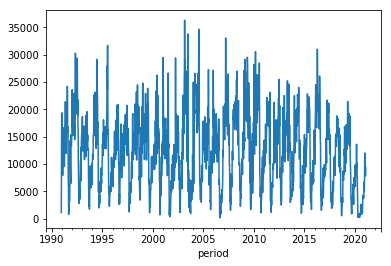

In [11]:
sorted_data['inc'].plot()

## Zoom sur les quatre dernières années
200 semaines ~4 ans

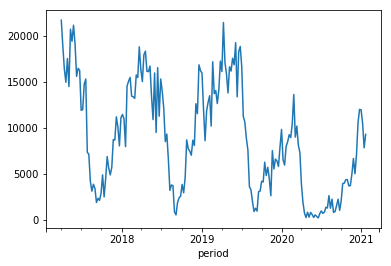

In [12]:
sorted_data['inc'][-200:].plot()

Le pic est beaucoup plus large que celui de la grippe.\
Le creux tombe pendant l'été. Août ou septembre ?\
Zoom plus poussé :

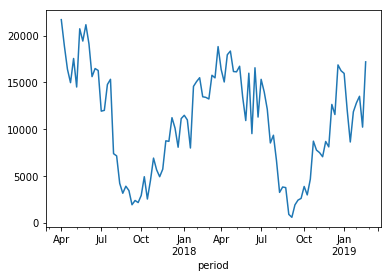

In [13]:
sorted_data['inc'][-200:-100].plot()

Le creux est donc plutôt vers septembre.\
Ca tombe bien, il est demandé les périodes d'étude au 1er septembre ;-)

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en septembre, nous définissons la période de référence
entre le 1er septembre de l'année $N$ et le 1er septembre de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er septembre de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er septembre.

L'incidence de la varicelle en cette période est plus faible que le reste de l'année, mais pas aussi faible que dan l'exemple de la grippe. Il faudra vérifieir si cette modification fausser nos conclusions.

Les données commencent fin 1990, ce qui rend la première année incomplète. Nous commençons donc l'analyse en septembre 1991.

In [14]:
first_sept_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [15]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_sept_week[:-1],
                        first_sept_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles :

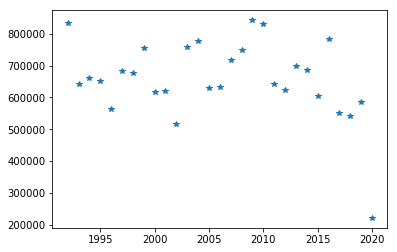

In [16]:
yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus faibles (au début) et les plus élevées (à la fin).

In [17]:
yearly_incidence.sort_values()

2020    221186
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Attention, il y a un piège - l'année 2020 n'est pas complète, puisqu'elle s'étende du 1er sept 2020 au 1er sept 2021.
Les bonnes réponses sont donc 2009 pour la plus forte, 2002 pour la plus faible.